# Methaheuristics - FSP

# Table de matière
* [NEH](#NEH)
* [Hill Climbing](#hillClimbing)
    * [Simple Hill Climbing](#SimpleHillClimbing)
    * [Steepest Hill Climbing](#SteepestHillClimbing)
    * [Stochastic Hill Climbing](#StochasticHillClimbing)
* [Recuit Simulé](#RecuitSimulé)
* [Simulated annealing](#TabuSearch)
* [Random walk](#Randomwalk)
* [Test](#Test)
    * [Test Hill Climbing](#testhillClimbing)
    * [Test Recuit Simulé](#testRecuitSimulé)
    * [Test Random walk](#testRandomwalk)
    * [Test Simulated annealing](#testTabuSearch)
    * [Comparaison](#comp)
    * [Test instances Taillard 20x5](#20x5)

In [1]:
# Importer les bibliothèques
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import random
from itertools import permutations
import json
import sys
import time
from collections import deque

# Fonction utils

In [2]:
# Lire le benchmark
def load_taillard(path='benchmarks/taillard.txt'):
    with open(path) as f:
        n = 10 # int(f.readline())
        tests = []
        tests_json = []
        for _ in range(n):
            test = {}
            next(f)
            nb_jobs, nb_machines, seed, ub, lb = [int(i) for i in f.readline().strip().split(" ") if i != ""]
            test["nb_jobs"] = nb_jobs
            test["nb_machines"] = nb_machines
            test["seed"] = seed
            test["upper_bound"] = ub
            test["lower_bound"] = lb
            next(f)
            jobs = []
            for _ in range(nb_machines):
                process_times = [int(i) for i in f.readline().strip().split(" ") if i != ""]
                jobs.append(process_times)
            test["jobs"] = list(zip(*jobs))
            tests_json.append(test)
            tests.append((nb_jobs, nb_machines, seed, ub, lb, list(zip(*jobs))))
    with open('benchmarks/taillard.json', 'w') as f:
        json.dump(tests_json, f)
    return tests_json

In [3]:
# Fonction qui retourne le cout d'une solution
def evaluate_sequence(sequence, processing_times):
    _, num_machines = processing_times.shape
    num_jobs = len(sequence)
    completion_times = np.zeros((num_jobs, num_machines))
    
    # Calculate the completion times for the first machine
    completion_times[0][0] = processing_times[sequence[0]][0]
    for i in range(1, num_jobs):
        completion_times[i][0] = completion_times[i-1][0] + processing_times[sequence[i]][0]
    
    # Calculate the completion times for the remaining machines
    for j in range(1, num_machines):
        completion_times[0][j] = completion_times[0][j-1] + processing_times[sequence[0]][j]
        for i in range(1, num_jobs):
            completion_times[i][j] = max(completion_times[i-1][j], completion_times[i][j-1]) + processing_times[sequence[i]][j]
    
    # Return the total completion time, which is the completion time of the last job in the last machine
    return completion_times[num_jobs-1][num_machines-1]

In [4]:
def compute_completion_time(sequence, processing_times):
    # Récupération du nombre de tâches et de machines
    m = processing_times.shape[1]
    n  = len(sequence)
    # Initialisation de la matrice des temps de complétion
    completion_times = np.zeros((n, m))

    # Parcours de la séquence de tâches
    for i in range(n):
        for j in range(m):
            if i == 0 and j == 0:
                # Pour la première tâche et la première machine, le temps de complétion est le temps de traitement
                completion_times[i][j] = processing_times[sequence[i]][j]
            elif i == 0:
                # Pour la première tâche sur les machines suivantes, ajoute le temps de traitement au temps de la machine précédente
                completion_times[i][j] = completion_times[i][j - 1] + processing_times[sequence[i]][j]
            elif j == 0:
                # Pour les tâches suivantes sur la première machine, ajoute le temps de traitement au temps de la tâche précédente
                completion_times[i][j] = completion_times[i - 1][j] + processing_times[sequence[i]][j]
            else:
                # Pour les tâches suivantes sur les machines suivantes, le temps de complétion est le maximum du temps précédent sur la même machine et du temps précédent sur la même tâche sur la machine actuelle, plus le temps de traitement
                completion_times[i][j] = max(completion_times[i - 1][j], completion_times[i][j - 1]) + processing_times[sequence[i]][j]

    # Retourne le temps de complétion de la dernière tâche sur la dernière machine
    return completion_times[-1][-1]

In [5]:
def generer_donnees_aleatoires(rows, cols, low=10, high=50):
    donnees_aleatoires = np.random.randint(low, high, size=(rows, cols))
    return donnees_aleatoires

In [6]:
def plot_gantt(durations, sol_indices):
    fig, ax = plt.subplots()
    # Setting up y-axis ticks
    ax.set_yticks(range(len(durations[1])))
    ax.set_yticklabels(["M" + str(i) for i in range(len(durations[1]))])

    # # Generate colors for jobs
    num_jobs, num_machines = durations.shape

    ax.set_xlabel('Time')
    ax.set_ylabel('Machines')
    ax.set_title('Flowshop Scheduling Gantt Diagram')
    colors = plt.cm.tab10(np.linspace(0, 1, num_jobs))

    job_start_times = [0] * len(durations)
    machine_start_times = [0] * len(durations[0])


    for i in sol_indices:
        for j in range(len(durations[i])):
            start_time = max(job_start_times[i], machine_start_times[j])
            duration = durations[i][j]
            color = colors[i]
            ax.barh(j, duration, left=start_time, color=color, align='center')
            ax.text(start_time + duration / 2, j, str(i), ha='center', va='center')  # Adding label for j
            job_start_times[i] = start_time + duration  # Update starting time for the job
            machine_start_times[j] = start_time + duration

    plt.show()

In [7]:
def plot_test(results_df, title):
    # Extract file names, upper bounds, and makespans
    file_names = results_df["File Name"]
    upper_bounds = results_df["Upper Bound"].astype(int)
    makespans = results_df["Makespan"].astype(int)

    # Generate positions for the bars
    positions = np.arange(len(file_names))

    # Plotting
    plt.figure(figsize=(10, 6))

    # Plot makespans as bars
    plt.bar(positions, makespans, color=(0.7, 0.85, 1.0), label='Makespan')

    # Plot upper bounds as red lines
    for i, (pos, upper_bound) in enumerate(zip(positions, upper_bounds)):
        if i == 0:
            plt.plot([pos-0.4, pos+0.4], [upper_bound, upper_bound], color='r', linestyle='--', label='Upper Bound')
        else:
            plt.plot([pos-0.4, pos+0.4], [upper_bound, upper_bound], color='r', linestyle='--')

        plt.text(pos, upper_bound-50, str(upper_bound), ha='center', va='top', color='r')
        plt.text(pos, makespans[i], str(makespans[i]), ha='center', va='bottom', color='k')

    # Add labels and title
    plt.xlabel('Instance')
    plt.ylabel('Makespan')
    plt.title(title)
    plt.xticks(positions, file_names)
    plt.legend()

    # Show plot
    plt.show()

# Les meta heuristiques

## NEH <a class="anchor" id="NEH"></a>

In [8]:
def Sorting_in_Descending_ordre(processing_times):
    #  Calculate the total completion time for each job
    total_completion_time = processing_times.sum(axis=1)

    #  Sort the jobs based on their total completion times in descending order
    sorted_job_indices = np.argsort(total_completion_time)[::-1]  # Sorting in descending order

    # Convert the sorted job indices to a list
    sorted_job_indices_list = sorted_job_indices.tolist()

    #  Return the sorted job indices
    return sorted_job_indices_list

In [9]:
def insertion(sequence, position, value):
    #  Create a copy of the original sequence
    new_seq = sequence[:]

    #  Insert the value at the specified position in the copied sequence
    new_seq.insert(position, value)

    #  Return the modified sequence
    return new_seq

In [10]:
def neh_algorithm(processing_times):
    ordered_sequence = Sorting_in_Descending_ordre(processing_times)
    # Define the initial order
    J1, J2 = ordered_sequence[:2]
    sequence = [J1, J2] if compute_completion_time([J1, J2], processing_times) < compute_completion_time([J2, J1], processing_times) else [J2, J1]
    del ordered_sequence[:2]
    # Add remaining jobs
    for job in ordered_sequence:
        Cmax = float('inf')
        best_sequence = []
        for i in range(len(sequence)+1):
            new_sequence = insertion(sequence, i, job)
            Cmax_eval = compute_completion_time(new_sequence, processing_times)
            if Cmax_eval < Cmax:
                Cmax = Cmax_eval
                best_sequence = new_sequence
        sequence = best_sequence
    return sequence, Cmax

In [11]:
processing_times = np.array([[54, 83, 15, 71, 77, 36, 53, 38, 27, 87, 76, 91, 14, 29, 12, 77, 32, 87, 68, 94],
                    [79, 3, 11, 99, 56, 70, 99, 60, 5, 56, 3, 61, 73, 75, 47, 14, 21, 86, 5, 77],
                    [16, 89, 49, 15, 89, 45, 60, 23, 57, 64, 7, 1, 63, 41, 63, 47, 26, 75, 77, 40],
                    [66, 58, 31, 68, 78, 91, 13, 59, 49, 85, 85, 9, 39, 41, 56, 40, 54, 77, 51, 31],
                    [58, 56, 20, 85, 53, 35, 53, 41, 69, 13, 86, 72, 8, 49, 47, 87, 58, 18, 68, 28]] ).T

Solution : [2, 16, 8, 7, 14, 13, 10, 15, 12, 18, 5, 3, 4, 17, 0, 1, 9, 6, 19, 11]
time  1286.0


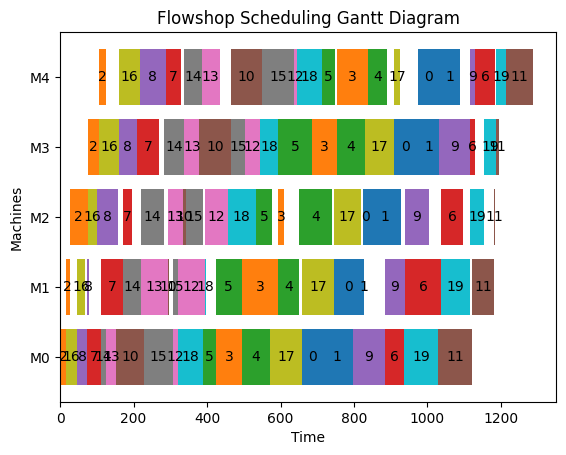

In [12]:
sol, Cmax = neh_algorithm(processing_times)
print("Solution :" ,  sol)
print("time " , Cmax)
plot_gantt(processing_times, sol)

## Hill Climbing <a class="anchor" id="hillClimbing"></a>

In [13]:
def best_first_swap(solution, processing_times):
    # Get the number of jobs in the solution
    num_jobs = len(solution)
    # Initialize variables to store the best neighbor solution and its makespan
    best_cmax = compute_completion_time(solution, processing_times)
    best_neighbor = solution.copy()

    # Iterate through all pairs of jobs in the sequence
    for job1 in range(num_jobs):
        for job2 in range(job1 + 1, num_jobs):
            # Generate a neighbor solution by swapping the positions of two jobs
            neighbor = solution.copy()
            neighbor = swap(neighbor, job1, job2)

            # Evaluate the makespan of the neighbor solution
            cmax = compute_completion_time(neighbor, processing_times)

            # Check if the neighbor solution improves upon the current best solution
            if cmax < best_cmax:
                # Update the best neighbor solution and its makespan
                best_neighbor = neighbor
                best_cmax = cmax

                # Return the first improved solution found
                return best_neighbor, best_cmax

    # If no improved solution is found, return the original solution and its makespan
    return best_neighbor, best_cmax

In [14]:
def swap(solution, i, k):
    # Swap the positions of the two jobs in the solution
    temp = solution[k]
    solution[k] = solution[i]
    solution[i] = temp

    # Return the solution with the swapped positions
    return solution

### Simple Hill Climbing <a class="anchor" id="SimpleHillClimbing"></a>

In [15]:
def simple_hill_climbing(solution, processing_times, nb_iter=100):
    """
    This function performs the simple hill climbing algorithm to improve a given solution
    to the flow shop scheduling problem.

    Args:
        solution (list): Current sequence of jobs on the machines.
        processing_times (dict): Dictionary containing processing times of jobs on each machine.
        nb_iter (int): Maximum number of iterations to perform (default is 10000).

    Returns:
        tuple: A tuple containing the improved solution, its corresponding makespan, and the number of iterations performed.
    """

    # Initialize variables
    x = solution  # Current solution
    cmax = compute_completion_time(solution, processing_times)  # Makespan of the current solution
    iterations = 0  # Counter for the number of iterations performed

    # Iterate until the maximum number of iterations is reached
    while iterations < nb_iter:
        # Find the best neighbor solution and its makespan
        best_neighbor, best_cmax = best_first_swap(x, processing_times)

        # If no improvement is found, return the current solution
        if best_cmax == cmax:
            return best_neighbor, best_cmax, iterations

        # Update the current solution and its makespan
        x = best_neighbor
        cmax = best_cmax

        # Increment the iteration counter
        iterations += 1

    # Return the best solution found, its makespan, and the number of iterations performed
    return x, cmax, iterations

In [16]:
def best_swap(solution, processing_times):
    """
    Find the best neighboring solution of the given solution.

    Args:
        solution (list): The current sequence of jobs on the machines.
        processing_times (dict): Dictionary containing processing times of jobs on each machine.

    Returns:
        tuple: A tuple containing the best neighbor solution and its corresponding makespan.
    """
    # Initialize variables
    num_jobs = len(solution)  # Number of jobs in the solution
    best_cmax = np.Infinity  # Initial best makespan set to infinity

    # Iterate through all possible pairs of jobs in the solution
    for k1 in range(num_jobs):
        for k2 in range(k1 + 1, num_jobs):
            # Generate a neighbor solution by swapping the positions of two jobs
            neighbor = solution.copy()
            neighbor = swap(neighbor, k1, k2)

            # Evaluate the makespan of the neighbor solution
            cmax = compute_completion_time(neighbor, processing_times)

            # Update the best neighbor solution if the makespan of the current neighbor is better
            if cmax < best_cmax:
                best_neighbor = neighbor
                best_cmax = cmax

    # Return the best neighbor solution and its corresponding makespan
    return best_neighbor, best_cmax

In [17]:
def best_swaps(solution, processing_times):
    """
    Generate a list of all neighboring solutions that are better than the given solution.

    Args:
        solution (list): The current sequence of jobs on the machines.
        processing_times (dict): Dictionary containing processing times of jobs on each machine.

    Returns:
        list: A list of tuples, each containing the makespan and corresponding solution for all better neighboring solutions.
    """
    # Initialize variables
    num_jobs = len(solution)  # Number of jobs in the solution
    cmax = compute_completion_time(solution, processing_times)  # Makespan of the current solution
    bests = []  # List to store all better neighboring solutions

    # Iterate through all possible pairs of jobs in the solution
    for job1 in range(num_jobs):
        for job2 in range(job1 + 1, num_jobs):
            # Generate a neighbor solution by swapping the positions of two jobs
            neighbor = solution.copy()
            swap(neighbor, job1, job2)

            # Evaluate the makespan of the neighbor solution
            neighbor_cmax = compute_completion_time(neighbor, processing_times)

            # If the neighbor solution has a better makespan than the current solution, add it to the list
            if neighbor_cmax < cmax:
                bests.append((neighbor_cmax, neighbor))

    # Sort the list of better neighboring solutions based on their makespan
    bests.sort(key=lambda x: x[0])

    # Return the list of better neighboring solutions
    return bests

### Steepest Ascent Hill Climbing  <a class="anchor" id="SteepestHillClimbing"></a>

In [18]:
def steepest_ascent_hill_climbing(solution, processing_times, nb_iter=1000):
    """
    Steepest Ascent Hill Climbing algorithm for flow shop scheduling problem.

    Args:
        solution (list): Current sequence of jobs on the machines.
        processing_times (dict): Dictionary containing processing times of jobs on each machine.
        nb_iter (int): Maximum number of iterations to perform (default is 1000).

    Returns:
        tuple: A tuple containing the improved solution, its corresponding makespan, and the number of iterations performed.
    """

    # Initialize variables
    x = solution  # Current solution
    cmax = compute_completion_time(solution, processing_times)  # Makespan of the current solution
    iterations = 0  # Counter for the number of iterations performed

    # Iterate until the maximum number of iterations is reached
    while iterations < nb_iter:
        # Find the best neighbor solution and its makespan
        best_neighbor, best_cmax = best_swap(solution, processing_times)  # Select the best neighbor solution

        # If the makespan of the best neighbor is worse than the current makespan, stop and return the current solution
        if best_cmax > cmax:
            return x, cmax  , iterations # If no better neighbor, return the current solution and its makespan

        # Update the current solution and its makespan
        else:
            x = best_neighbor
            cmax = best_cmax
            iterations += 1  # Move to the best neighbor solution and increment iteration count

    # Return the best solution found, its makespan, and the number of iterations performed
    return best_neighbor, best_cmax, iterations  # Return the best solution found after reaching maximum iterations

### Stochastic Hill Climbing <a class="anchor" id="StochasticHillClimbing"></a>

In [19]:
def stochastic_hill_climbing(solution, processing_times, nb_iter=1000):
  """
  Stochastic Hill Climbing algorithm for flow shop scheduling problem.

  Args:
      solution (list): Current sequence of jobs on the machines.
      processing_times (dict): Dictionary containing processing times of jobs on each machine.
      nb_iter (int): Maximum number of iterations to perform (default is 1000).

  Returns:
      tuple: A tuple containing the improved solution, its corresponding makespan, and the number of iterations performed.
  """

  # Initialize variables
  x = solution  # Current solution
  cmax = compute_completion_time(solution, processing_times)  # Makespan of the current solution
  iterations = 0  # Counter for the number of iterations performed

  # Iterate until the maximum number of iterations is reached
  while iterations < nb_iter:
    # Get the best neighboring solutions
    best_neighbours = best_swaps(x, processing_times)

    # If there are no better neighboring solutions, return the current solution
    if len(best_neighbours) == 0:
      return x, cmax, iterations

    # Select a random best neighbor
    i = random.randint(0, len(best_neighbours) - 1)
    best_cmax, best_neighbor = best_neighbours[i]

    # If the makespan of the best neighbor is worse than the current makespan, return the current solution
    if best_cmax > cmax:
      return x, cmax, iterations

    # Update the current solution and its makespan
    x = best_neighbor
    cmax = best_cmax
    iterations += 1  # Increment iteration counter

  # Return the best solution found, its makespan, and the number of iterations performed
  return best_neighbor, best_cmax, iterations  # Return the best solution found after reaching maximum iterations

In [20]:
initial_solution , Cmax = neh_algorithm(processing_times)
print("Initial solution:", initial_solution)
print("Makespan:", Cmax)

start_time = time.time()
best_solution, best_cmax, nb_iterations = stochastic_hill_climbing(initial_solution, processing_times)
elapsed_time = time.time() - start_time

print("\nGenerated solution:", best_solution)
print("Makespan:", best_cmax)
print("Number of iterations:", nb_iterations)
print("\nElapsed time:", elapsed_time, "seconds")

Initial solution: [2, 16, 8, 7, 14, 13, 10, 15, 12, 18, 5, 3, 4, 17, 0, 1, 9, 6, 19, 11]
Makespan: 1286.0

Generated solution: [2, 16, 8, 7, 14, 13, 10, 15, 12, 18, 5, 3, 4, 17, 0, 1, 9, 6, 19, 11]
Makespan: 1286.0
Number of iterations: 0

Elapsed time: 0.05884385108947754 seconds


## Random walk <a class="anchor" id="Randomwalk"></a>

In [23]:
# Permuter deux jobs aléatoirement
def random_swap(solution, processing_times):
    i = np.random.choice(list(solution))
    k = np.random.choice(list(solution))
    
    # Generating two different random positions
    while (i == k):
        k = np.random.choice(list(solution))
    # Switch between job i and job k in the given sequence
    neighbor = solution.copy()
    return swap(neighbor, i, k), evaluate_sequence(neighbor, processing_times)

In [24]:
def random_walk(init_solution, processing_times, max_iterations=1000, threshold=None):
    current_solution = init_solution
    current_cost = evaluate_sequence(init_solution, processing_times)
    iterations = 0
    while iterations < max_iterations:
        current_solution, current_cost = random_swap(current_solution, processing_times)
        if threshold is not None and current_cost < threshold:
            return current_solution, current_cost, iterations
        iterations += 1
    return current_solution, current_cost, iterations


In [25]:
# Generate a random example to work with 7 jobs and 2 machines
rnd_data = np.random.randint(size=(15,10), low=5, high=120)
permutation = np.random.permutation(15).tolist()
print(rnd_data, "\n")
print('Initial solution:', permutation, "\n")

Cmax = evaluate_sequence(permutation, rnd_data)
print(f'Makespan: {Cmax}')

[[112 116 110  20  46  69  82  16  19  39]
 [ 80  97  70  84 118  94 100  42  49  39]
 [ 70  34  32 118   7  19 100  49  51 108]
 [ 87  58  59  25 105 100  80  52  36 117]
 [ 61  12  69  57  14  69 110  98  50 119]
 [ 80 118  36  64 107 119  32 109  51  95]
 [ 11  76 119  59  90  37  97  65  93  46]
 [108  96 102  28  56  24  28  64  16  16]
 [ 40  42 119  68  23  63  35  70 110   6]
 [ 55  97  38  70 118  46  46 110  35  18]
 [ 79  99  85  95  14   6  46  90  89  47]
 [100  66  95  85  78  59  96  35  33 107]
 [ 40  74  29  31  63  49  58  81  32 103]
 [ 74  40  53 117  20 117  74  95  38   6]
 [109  19 115  76 117  84 111  61  23   9]] 

Initial solution: [0, 12, 9, 1, 3, 7, 13, 14, 10, 11, 5, 2, 8, 6, 4] 

Makespan: 2130.0


In [26]:
print("Initial solution:", permutation)
print("Makespan:", Cmax)

start_time = time.time()
neighbor, neighbor_cmax, iterations = random_walk(permutation, rnd_data, threshold=1700, max_iterations=10000)
elapsed_time = time.time() - start_time

print("\nGenerated solution:", neighbor)
print("Makespan:", neighbor_cmax)
print("Number of iterations:", iterations)
print("\nElapsed time:", elapsed_time, "seconds")

Initial solution: [0, 12, 9, 1, 3, 7, 13, 14, 10, 11, 5, 2, 8, 6, 4]
Makespan: 2130.0



Generated solution: [3, 11, 12, 14, 2, 4, 8, 13, 9, 10, 6, 0, 5, 7, 1]
Makespan: 1976.0
Number of iterations: 10000

Elapsed time: 3.861569404602051 seconds


## VNS <a class="anchor" id="VNS"></a>

#### neighborhood structures

In [27]:
def random_insertion(solution, processing_times):
    # This function consists of choosing random two indices, i and k.
    # Remove the element at indice i, and insert it in the position k.
    i = np.random.choice(list(solution))
    k = np.random.choice(list(solution))
    while (i == k):
        k = np.random.choice(list(solution))
    neighbor = solution.copy()
    neighbor.remove(solution[i])
    neighbor.insert(k, solution[i])
    return neighbor, evaluate_sequence(neighbor, processing_times)

In [28]:
def swap_sequence(solution, processing_times):
    s = solution.copy()
    midpoint = len(s) // 2 + 1
    # Swap the first half with the second half
    s[:midpoint], s[midpoint:] = s[midpoint:], s[:midpoint]
    cost = evaluate_sequence(s, processing_times)
    return s, cost

In [29]:
def random_subarray_move_to_start(solution, processing_times):
    s = solution.copy()
    # Randomly choose indices i and j
    i, j = np.random.randint(0, len(s), size=2)
    i, j = min(i, j), max(i, j)  # Ensure i < j
    # Extract the subarray from index i to j
    subarray = s[i:j+1]
    # Move the subarray to the beginning of the array
    new_solution = np.concatenate((subarray, s[:i], s[j+1:]))
    new_solution = new_solution.tolist()
    cost = evaluate_sequence(new_solution, processing_times)
    return new_solution, cost

In [30]:
def get_neighbor(solution, processing_times, method=1): #"random_swap"):
    # Swapping methods
    if method == 1: #"random_swap":
        neighbor, cost = random_swap(solution, processing_times)
    elif method == 2: #"best_swap":
        neighbor, cost = swap_sequence(solution, processing_times)
    # Insertion methods
    elif method == 3: #"random_insertion":
        neighbor, cost = random_insertion(solution, processing_times)
    # Randomly pick a method of generating neighbors.    
    return neighbor, cost

In [31]:
def swap_jobs(solution, i, j):
    # Swap the positions of two jobs in the solution
    solution[i], solution[j] = solution[j], solution[i]

In [32]:
def local_search(solution, processing_times):
    # Apply a simple swap-based local search
    improved = True
    while improved:
        improved = False
        for i in range(len(solution)):
            for j in range(i + 1, len(solution)):
                # Evaluate the solution after swapping jobs i and j
                new_solution = solution.copy()
                swap_jobs(new_solution, i, j)
                new_makespan = evaluate_sequence(new_solution, processing_times)

                # Accept the new solution if it improves the makespan
                if new_makespan < evaluate_sequence(solution, processing_times):
                    solution = new_solution
                    improved = True
                    break  # Exit inner loop

    return solution

In [33]:
def vns(sol_init, processing_times, max_iterations, k_max):
    current_solution = sol_init
    current_cost = evaluate_sequence(current_solution, processing_times)
    iteration = 0
    while iteration < max_iterations:       
        k = 1
        while k < k_max:
            # ======== shake ========
            best_neighbor_solution, best_neighbor_cost = get_neighbor(current_solution, processing_times, method=k) # shake(current_solution, k)
            # best_neighbor_cost = evaluate_sequence(best_neighbor_solution, processing_times)
            
            # ======== local search (Best Improvement) ========
            """ for _ in range(1, k_max+1):
                neighbor, neighbor_cost  = get_neighbor(best_neighbor_solution, processing_times, method="random")
                if (neighbor_cost < best_neighbor_cost):
                    best_neighbor_solution = neighbor
                    best_neighbor_cost = neighbor_cost """
            best_neighbor_solution = local_search(best_neighbor_solution, processing_times) 
            best_neighbor_cost = evaluate_sequence(best_neighbor_solution, processing_times)           
            
            # ======== change neighborhood ========
            if ( best_neighbor_cost < current_cost ):
                current_solution = best_neighbor_solution # Make a move
                current_cost = best_neighbor_cost
                k = 1 # Initial neighborhood
            else:
                k += 1 # Next neighborhood

        iteration += 1
    return current_solution, current_cost

In [34]:
# Generate a random example to work with 7 jobs and 2 machines
rnd_data = np.random.randint(size=(15,10), low=5, high=120)
permutation = np.random.permutation(15).tolist()
print(rnd_data, "\n")
print('Initial solution:', permutation, "\n")

Cmax = evaluate_sequence(permutation, rnd_data)
print(f'Makespan: {Cmax}')

[[ 35  51  53 104 102  10  52  35  84  66]
 [110 103   6  98  55  12  35 103  98  13]
 [ 26  15  79 108  59  44 100  31  66  37]
 [ 40  24   5  79  85 119  18  14 109  14]
 [ 82  13  90  31   5  50  20  27 110  53]
 [ 99  75 112  67  88 116  47 110 118  29]
 [ 85  41  23  52  66  88  35  71  56  54]
 [ 63  74  54  22  22  55 117 108  87  15]
 [ 79  73   8  87  44 103  94  59  26  23]
 [ 26  27  92  51  41  81  69  54   5  77]
 [ 94   5  28  23  86  43 109 119   9  58]
 [ 55 101  46  98  42  37  53  80  68  60]
 [ 96  99 110  77  54  82  62  71  47  33]
 [113  58 116  99  97  22  31  37  27  51]
 [ 61  65  91  40 105  88  62  90  14  47]] 

Initial solution: [11, 7, 10, 4, 1, 14, 12, 0, 9, 13, 6, 2, 8, 3, 5] 

Makespan: 2091.0


In [35]:
print("Initial solution:", permutation)
print("Makespan:", Cmax)

start_time = time.time()
neighbor, neighbor_cmax = vns(permutation, rnd_data, max_iterations=10, k_max=4)
elapsed_time = time.time() - start_time

print("\nGenerated solution:", neighbor)
print("Makespan:", neighbor_cmax)
print("\nElapsed time:", elapsed_time, "seconds")

Initial solution: [11, 7, 10, 4, 1, 14, 12, 0, 9, 13, 6, 2, 8, 3, 5]
Makespan: 2091.0



Generated solution: [2, 14, 0, 11, 7, 6, 9, 3, 1, 5, 10, 4, 8, 12, 13]
Makespan: 1644.0

Elapsed time: 9.030565977096558 seconds


## Simulated annealing <a class="anchor" id="RecuitSimulé"></a>

In [36]:
from random import randint
class Flowshop(object):
    """
    A class for initiaizing & solving a Permutation Flowshop Scheduling Problem
    """

    def __init__(self, data=None, nb_machines=2, nb_jobs=6):
        """[summary]

        Keyword Arguments:
            data {list} -- A 2D array of processing time on machines (default: {None})
            nb_machines {int} -- Number of machines for the given problem must be the number of rows of first param (default: {2})
            nb_jobs {[type]} -- Number of jobs for the given problem, must be equal to the number of columns of the data param. (default: {6})
        """

        self.nb_machines = nb_machines
        self.nb_jobs = nb_jobs
        if data is not None:
            self.data = data

    def solve_johnson(self):
        """Solves a permutation flowshop problem using johnson's rule for a permutation problem of 2 machines and N jobs

        Raises:
            Exception: Raises exception when given a problem with more than 2 machines

        Returns:
            tuple -- returns a tuple containing the optimal sequence of scheduled jobs and a list of scheduled jobs on the 2 machines
        """

        if self.nb_machines != 2:
            raise Exception(
                "Johnson's algorithm only possible for a 2 machine problem"
            )
        default_timer = None
        if sys.platform == "win32":
            default_timer = time.time
        else:
            default_timer = time.time
        s = default_timer.__call__()
        # Build optimal sequence array
        machine_1_sequence = [j for j in range(
            self.nb_jobs) if self.data[0][j] <= self.data[1][j]]
        machine_1_sequence.sort(key=lambda x: self.data[0][x])
        machine_2_sequence = [j for j in range(
            self.nb_jobs) if self.data[0][j] > self.data[1][j]]
        machine_2_sequence.sort(key=lambda x: self.data[1][x], reverse=True)
        seq = machine_1_sequence + machine_2_sequence
        e = default_timer.__call__()
        jobs_m1, jobs_m2 = [], []
        job_name_rad = "job_"
        job = {"name": job_name_rad +
               str(
                   seq[0]+1,
               ),
               "start_time": 0,
               "end_time": self.data[0][seq[0]]}
        jobs_m1.append(job)
        job = {"name": job_name_rad+str(seq[0]+1), "start_time": self.data[0]
               [seq[0]],
               "end_time": self.data[0][seq[0]] + self.data[1][seq[0]]}
        jobs_m2.append(job)

        for job_id in seq[1::]:
            # job on machine 1
            job_name = job_name_rad + str(job_id + 1)
            job_start_m1 = jobs_m1[-1]["end_time"]
            job_end_m1 = job_start_m1 + self.data[0][job_id]
            job = {"name": job_name, "start_time": job_start_m1,
                   "end_time": job_end_m1}
            jobs_m1.append(job)

            # job on machine 2
            job_start_m2 = max(job_end_m1, jobs_m2[-1]["end_time"])
            job_end_m2 = job_start_m2 + self.data[1][job_id]

            job = {"name": job_name, "start_time": job_start_m2,
                   "end_time": job_end_m2}
            jobs_m2.append(job)
        optim_makespan = int(jobs_m2[-1]["end_time"])
        t_t = e - s
        return seq, [jobs_m1, jobs_m2], optim_makespan, t_t

    @staticmethod
    def johnson_seq(data):
        # data matrix must have only two machines
        nb_machines = len(data)
        nb_jobs = len(data[0])
        machine_1_sequence = [j for j in range(
            nb_jobs) if data[0][j] <= data[1][j]]
        machine_1_sequence.sort(key=lambda x: data[0][x])
        machine_2_sequence = [j for j in range(
            nb_jobs) if data[0][j] > data[1][j]]
        machine_2_sequence.sort(key=lambda x: data[1][x], reverse=True)
        seq = machine_1_sequence + machine_2_sequence
        return seq

    @staticmethod
    def johnson_seq_var_2(data):
        job_count = len(data)
        job_ids = list(range(0, job_count))
        l1 = []
        l2 = []
        for job_info in sorted(zip(job_ids, data), key=lambda t: min(t[1])):
            job_id = job_info[0]
            job_times = job_info[1]
            if job_times[0] < job_times[1]:
                l1.append(job_id)
            else:
                l2.insert(0, job_id)
        return l1 + l2

    def cds(self):
        if type(self.data) is not np.ndarray:
            data_ndarray = np.array(self.data)
        else:
            data_ndarray = self.data
        data_transposed = data_ndarray.T
        default_timer = None
        if sys.platform == "win32":
            default_timer = time.time
        else:
            default_timer = time.time
        s = default_timer.__call__()

        merged_times = [[0, sum(j_t)] for j_t in data_transposed]
        perms = []
        for i in range(0, self.nb_machines-1):
            for j in range(0, self.nb_jobs):
                merged_times[j][0] += data_transposed[j][i]
                merged_times[j][1] -= data_transposed[j][i]
            perms.append(Flowshop.johnson_seq_var_2(merged_times))

        seq = min(perms, key=lambda p: self._get_makespan(p, self.data))

        e = default_timer.__call__()

        schedules = np.zeros((self.nb_machines, self.nb_jobs), dtype=dict)
        # schedule first job alone first
        task = {"name": "job_{}".format(
            seq[0]+1), "start_time": 0, "end_time": self.data[0][seq[0]]}
        schedules[0][0] = task
        for m_id in range(1, self.nb_machines):
            start_t = schedules[m_id-1][0]["end_time"]
            end_t = start_t + self.data[m_id][0]
            task = {"name": "job_{}".format(
                seq[0]+1), "start_time": start_t, "end_time": end_t}
            schedules[m_id][0] = task

        for index, job_id in enumerate(seq[1::]):
            start_t = schedules[0][index]["end_time"]
            end_t = start_t + self.data[0][job_id]
            task = {"name": "job_{}".format(
                job_id+1), "start_time": start_t, "end_time": end_t}
            schedules[0][index+1] = task
            for m_id in range(1, self.nb_machines):
                start_t = max(schedules[m_id][index]["end_time"],
                              schedules[m_id-1][index+1]["end_time"])
                end_t = start_t + self.data[m_id][job_id]
                task = {"name": "job_{}".format(
                    job_id+1), "start_time": start_t, "end_time": end_t}
                schedules[m_id][index+1] = task
        max_mkspn = int(schedules[self.nb_machines-1][-1]["end_time"])
        t_t = e - s
        return seq, schedules, max_mkspn, t_t

    def palmer_heuristic(self):
        """solves an N machines M jobs pfsp problem using Palmer's Heuristic
        Returns:
            tuple -- a tuple containing the job sequence, scheduled jobs and optimal makespan.
        """

        def palmer_f(x): return -(self.nb_machines - (2*x - 1))

        default_timer = None
        if sys.platform == "win32":
            default_timer = time.time
        else:
            default_timer = time.time
        s = default_timer.__call__()

        weights = list(map(palmer_f, range(1, self.nb_machines+1)))
        ws = []
        for job_id in range(self.nb_jobs):
            p_ij = sum([self.data[j][job_id]*weights[j]
                        for j in range(self.nb_machines)])
            ws.append((job_id, p_ij))
        ws.sort(key=lambda x: x[1], reverse=True)
        h_seq = [x[0] for x in ws]
        e = default_timer.__call__()
        schedules = np.zeros((self.nb_machines, self.nb_jobs), dtype=dict)
        # schedule first job alone first
        task = {"name": "job_{}".format(
            h_seq[0]+1), "start_time": 0, "end_time": self.data[0][h_seq[0]]}
        schedules[0][0] = task
        for m_id in range(1, self.nb_machines):
            start_t = schedules[m_id-1][0]["end_time"]
            end_t = start_t + self.data[m_id][0]
            task = {"name": "job_{}".format(
                h_seq[0]+1), "start_time": start_t, "end_time": end_t}
            schedules[m_id][0] = task

        for index, job_id in enumerate(h_seq[1::]):
            start_t = schedules[0][index]["end_time"]
            end_t = start_t + self.data[0][job_id]
            task = {"name": "job_{}".format(
                job_id+1), "start_time": start_t, "end_time": end_t}
            schedules[0][index+1] = task
            for m_id in range(1, self.nb_machines):
                start_t = max(schedules[m_id][index]["end_time"],
                              schedules[m_id-1][index+1]["end_time"])
                end_t = start_t + self.data[m_id][job_id]
                task = {"name": "job_{}".format(
                    job_id+1), "start_time": start_t, "end_time": end_t}
                schedules[m_id][index+1] = task
        opt_makespan = int(schedules[self.nb_machines-1][-1]["end_time"])
        t_t = e - s
        return h_seq, schedules, opt_makespan, t_t

    def _get_makespan(self, seq, data):
        c = np.zeros((self.nb_machines, len(seq)), dtype=object)
        c[0][0] = (0, data[0][seq[0]])
        for m_id in range(1, self.nb_machines):
            s_t = c[m_id-1][0][1]
            e_t = s_t + data[m_id][0]
            c[m_id][0] = (s_t, e_t)
        if len(seq) > 1:
            for i, job_id in enumerate(seq[1::]):
                s_t = c[0][i][1]
                e_t = s_t + data[0][job_id]
                c[0][i+1] = (s_t, e_t)
                for m_id in range(1, self.nb_machines):
                    s_t = max(c[m_id][i][1], c[m_id-1][i+1][1])
                    e_t = s_t + data[m_id][job_id]
                    c[m_id][i+1] = (s_t, e_t)
        return c[self.nb_machines-1][-1][1]

    def neh_heuristic(self):
        sums = []
        default_timer = None
        if sys.platform == "win32":
            default_timer = time.time
        else:
            default_timer = time.time
        s = default_timer.__call__()

        for job_id in range(self.nb_jobs):
            p_ij = sum([self.data[j][job_id]
                        for j in range(self.nb_machines)])
            sums.append((job_id, p_ij))
        sums.sort(key=lambda x: x[1], reverse=True)
        seq = []
        for job in sums:
            cands = []
            for i in range(0, len(seq) + 1):
                cand = seq[:i] + [job[0]] + seq[i:]
                cands.append((cand, self._get_makespan(cand, self.data)))
            seq = min(cands, key=lambda x: x[1])[0]

        e = default_timer.__call__()

        schedules = np.zeros((self.nb_machines, self.nb_jobs), dtype=dict)
        # schedule first job alone first
        task = {"name": "job_{}".format(
            seq[0]+1), "start_time": 0, "end_time": self.data[0][seq[0]]}
        schedules[0][0] = task
        for m_id in range(1, self.nb_machines):
            start_t = schedules[m_id-1][0]["end_time"]
            end_t = start_t + self.data[m_id][0]
            task = {"name": "job_{}".format(
                seq[0]+1), "start_time": start_t, "end_time": end_t}
            schedules[m_id][0] = task

        for index, job_id in enumerate(seq[1::]):
            start_t = schedules[0][index]["end_time"]
            end_t = start_t + self.data[0][job_id]
            task = {"name": "job_{}".format(
                job_id+1), "start_time": start_t, "end_time": end_t}
            schedules[0][index+1] = task
            for m_id in range(1, self.nb_machines):
                start_t = max(schedules[m_id][index]["end_time"],
                              schedules[m_id-1][index+1]["end_time"])
                end_t = start_t + self.data[m_id][job_id]
                task = {"name": "job_{}".format(
                    job_id+1), "start_time": start_t, "end_time": end_t}
                schedules[m_id][index+1] = task
        max_mkspn = int(schedules[self.nb_machines-1][-1]["end_time"])

        t_t = e - s
        return seq, schedules, max_mkspn, t_t

    def swapTwoJobs(self,seq,pos1,pos2):
        seq[pos1], seq[pos2] = seq[pos2], seq[pos1]
        return seq

    def simulated_annealing(self,Ti = 790,Tf = 3 ,alpha = 0.93):
        #Number of jobs given
        n = self.nb_jobs
        default_timer = None
        if sys.platform == "win32":
            default_timer = time.time
        else:
            default_timer = time.time
        s = default_timer.__call__()
        #Initialize the primary seq
        old_seq,schedules,old_makeSpan, _ = self.cds()
        new_seq = []
        delta_mk1 = 0
        #Initialize the temperature
        T = Ti
        Tf = Tf
        alpha = alpha
        # of iterations
        temp_cycle = 0
        while T >= Tf  :
            new_seq = old_seq.copy()
            job = new_seq.pop(randint(0,n-1))
            new_seq.insert(randint(0,n-1),job)
            new_make_span = self._get_makespan(new_seq,self.data)
            delta_mk1 = new_make_span - old_makeSpan
            if delta_mk1 <= 0:
              old_seq = new_seq
              old_makeSpan = new_make_span
            else :
              Aprob = np.exp(-(delta_mk1/T))
              if Aprob > np.random.uniform(0.5,0.9):
                  old_seq = new_seq
                  old_makeSpan = new_make_span

            T = T * alpha
            temp_cycle += 1

        e = default_timer.__call__()
        #Result Sequence
        seq = old_seq
        schedules = np.zeros((self.nb_machines, self.nb_jobs), dtype=dict)
        # schedule first job alone first
        task = {"name": "job_{}".format(seq[0] + 1), "start_time": 0, "end_time": self.data[0][seq[0]]}
        schedules[0][0] = task
        for m_id in range(1, self.nb_machines):
            start_t = schedules[m_id - 1][0]["end_time"]
            end_t = start_t + self.data[m_id][0]
            task = {"name": "job_{}".format(seq[0] + 1), "start_time": start_t, "end_time": end_t}
            schedules[m_id][0] = task

        for index, job_id in enumerate(seq[1::]):
            start_t = schedules[0][index]["end_time"]
            end_t = start_t + self.data[0][job_id]
            task = {"name": "job_{}".format(
                job_id + 1), "start_time": start_t, "end_time": end_t}
            schedules[0][index + 1] = task
            for m_id in range(1, self.nb_machines):
                start_t = max(schedules[m_id][index]["end_time"],
                              schedules[m_id - 1][index + 1]["end_time"])
                end_t = start_t + self.data[m_id][job_id]
                task = {"name": "job_{}".format(
                    job_id + 1), "start_time": start_t, "end_time": end_t}
                schedules[m_id][index + 1] = task
        t_t = e - s

        return seq, schedules, old_makeSpan, t_t

# Tests <a class="anchor" id="Test"></a>

In [37]:
import os

def list_files_in_folder(folder_path, num_files=12):
    files = os.listdir(folder_path)
    return files[:num_files]

folder_path = "benchmarks"
file_names = list_files_in_folder(folder_path)
file_names = ['tai20_10.txt', 'tai20_20.txt', 'tai20_5.txt', 'tai50_10.txt', 'tai50_5.txt']

### random walk <a class="anchor" id="testRandomwalk"></a>

In [38]:
results_df = pd.DataFrame(columns=["File Name", "Instance", "Upper Bound", "Initial solution", "Makespan"])

for file_name in file_names:
    print(file_name)
    taillard = load_taillard(path="benchmarks/"+file_name)
    data = np.array(taillard[0]['jobs'])
    permutation = np.random.permutation(len(data)).tolist()
    initial_solution = evaluate_sequence(permutation, data)
    neighbor, neighbor_cmax, iterations  = random_walk(permutation , data, threshold=None, max_iterations=1000)
    
    new_row = pd.DataFrame({"File Name": [file_name[:-4]],
                                    #"Generated Solution": neighbor,
                                    "Instance": [0],
                                    "Upper Bound": [taillard[0]['upper_bound']],
                                    "Initial solution": [int(initial_solution)],
                                    "Makespan": [int(neighbor_cmax)]})
    
    results_df = pd.concat([results_df, new_row], ignore_index=True)
    
results_df
# plot_gantt(np.array(data), neighbor)

tai20_10.txt
tai20_20.txt
tai20_5.txt
tai50_10.txt
tai50_5.txt


,File Name,Instance,Upper Bound,Initial solution,Makespan
0,tai20_10,0,1582,2140,2157
1,tai20_20,0,2297,2928,2679
2,tai20_5,0,1278,1543,1510
3,tai50_10,0,3025,3741,3931
4,tai50_5,0,2724,3141,3255


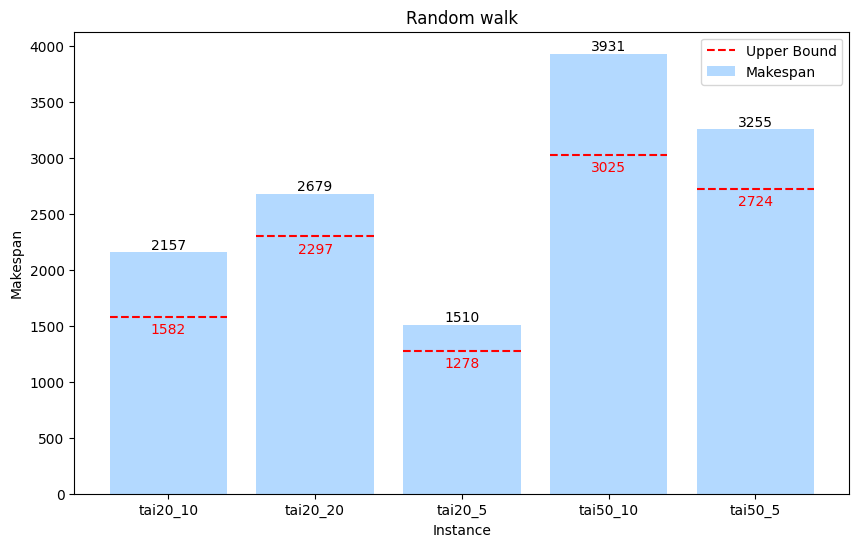

In [39]:
plot_test(results_df,"Random walk")

### VNS <a class="anchor" id="testVNS"></a>

In [40]:
results_df2 = pd.DataFrame(columns=["File Name", "Instance", "Upper Bound", "Initial solution", "Makespan"])
for file_name in file_names:
    print(file_name)
    taillard = load_taillard(path="benchmarks/"+file_name)
    data = np.array(taillard[0]['jobs'])
    permutation = np.random.permutation(len(data)).tolist()
    initial_solution = evaluate_sequence(permutation, data)
    neighbor, neighbor_cmax = vns(permutation, data, max_iterations=5, k_max=3)
    
    new_row = pd.DataFrame({"File Name": [file_name[:-4]],
                                    #"Generated Solution": neighbor,
                                    "Instance": [0],
                                    "Upper Bound": [taillard[0]['upper_bound']],
                                    "Initial solution": [int(initial_solution)],
                                    "Makespan": [int(neighbor_cmax)]})
    
    results_df2 = pd.concat([results_df2, new_row], ignore_index=True)
    
results_df2
# plot_gantt(np.array(data), neighbor)

tai20_10.txt
tai20_20.txt
tai20_5.txt
tai50_10.txt
tai50_5.txt


,File Name,Instance,Upper Bound,Initial solution,Makespan
0,tai20_10,0,1582,2076,1597
1,tai20_20,0,2297,2825,2380
2,tai20_5,0,1278,1413,1297
3,tai50_10,0,3025,3643,3088
4,tai50_5,0,2724,3261,2730


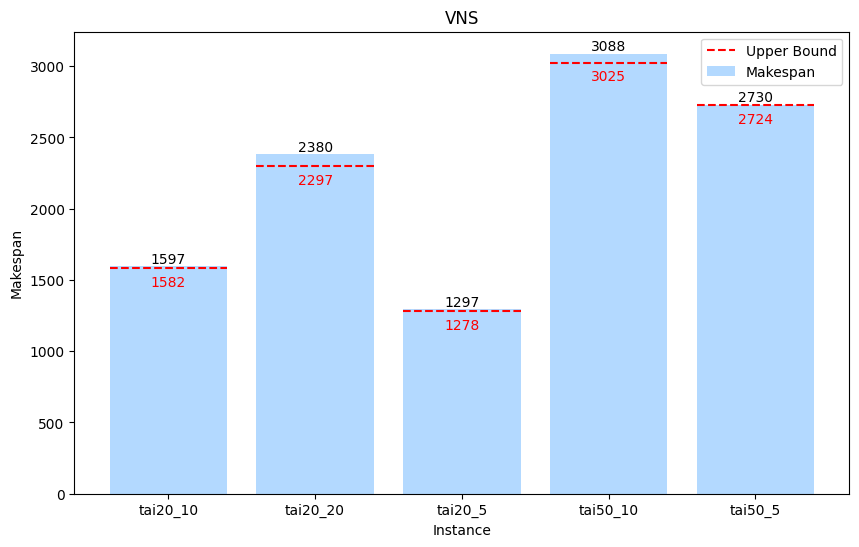

In [41]:
plot_test(results_df2,"VNS")

### Hill climbing <a class="anchor" id="testhillClimbing"></a>

In [42]:
results_df3 = pd.DataFrame(columns=["File Name", "Instance", "Upper Bound", "Initial solution", "Makespan"])
for file_name in file_names:
    print(file_name)
    taillard = load_taillard(path="benchmarks/"+file_name)
    data = np.array(taillard[0]['jobs'])
    permutation = np.random.permutation(len(data)).tolist()
    permutation , initial_solution = neh_algorithm(data.T)
    neighbor, neighbor_cmax, _ = simple_hill_climbing(permutation, data.T , 10000)
    
    new_row = pd.DataFrame({"File Name": [file_name[:-4]],
                                    #"Generated Solution": neighbor,
                                    "Instance": [0],
                                    "Upper Bound": [taillard[0]['upper_bound']],
                                    "Initial solution": [int(initial_solution)],
                                    "Makespan": [int(neighbor_cmax)]})
    
    results_df3 = pd.concat([results_df3, new_row], ignore_index=True)
        
results_df3
# plot_gantt(np.array(data), neighbor)

tai20_10.txt
tai20_20.txt
tai20_5.txt
tai50_10.txt
tai50_5.txt


,File Name,Instance,Upper Bound,Initial solution,Makespan
0,tai20_10,0,1582,1769,1736
1,tai20_20,0,2297,2391,2343
2,tai20_5,0,1278,1358,1358
3,tai50_10,0,3025,3513,3480
4,tai50_5,0,2724,2899,2899


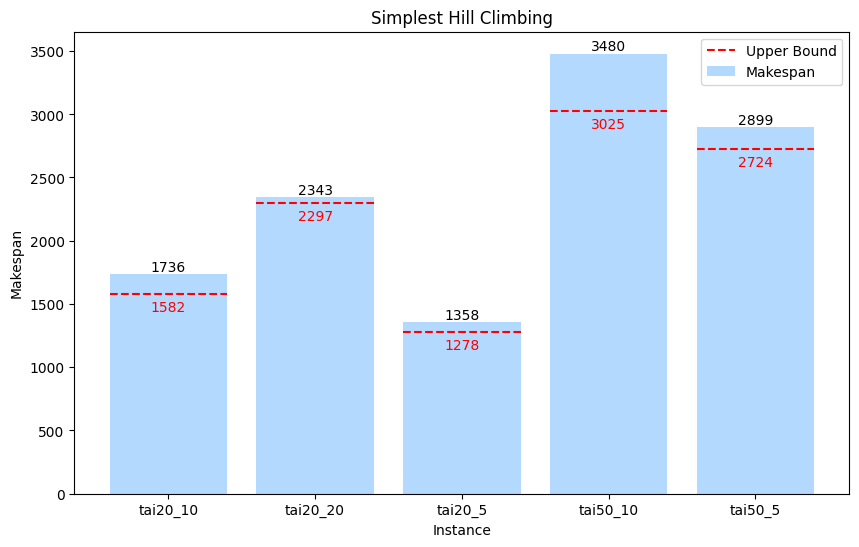

In [43]:
plot_test(results_df3,"Simplest Hill Climbing")

In [44]:
results_df4 = pd.DataFrame(columns=["File Name", "Instance", "Upper Bound", "Initial solution", "Makespan"])
for file_name in file_names:
    print(file_name)
    taillard = load_taillard(path="benchmarks/"+file_name)
    data = np.array(taillard[0]['jobs'])
    permutation = np.random.permutation(len(data)).tolist()
    permutation , initial_solution = neh_algorithm(data.T)
    neighbor, neighbor_cmax, _ = steepest_ascent_hill_climbing(permutation, data.T)
    
    new_row = pd.DataFrame({"File Name": [file_name[:-4]],
                                    #"Generated Solution": neighbor,
                                    "Instance": [0],
                                    "Upper Bound": [taillard[0]['upper_bound']],
                                    "Initial solution": [int(initial_solution)],
                                    "Makespan": [int(neighbor_cmax)]})
    
    results_df4 = pd.concat([results_df4, new_row], ignore_index=True)
        
results_df4
# plot_gantt(np.array(data), neighbor)

tai20_10.txt
tai20_20.txt
tai20_5.txt
tai50_10.txt
tai50_5.txt


,File Name,Instance,Upper Bound,Initial solution,Makespan
0,tai20_10,0,1582,1769,1749
1,tai20_20,0,2297,2391,2380
2,tai20_5,0,1278,1358,1358
3,tai50_10,0,3025,3513,3480
4,tai50_5,0,2724,2899,2899


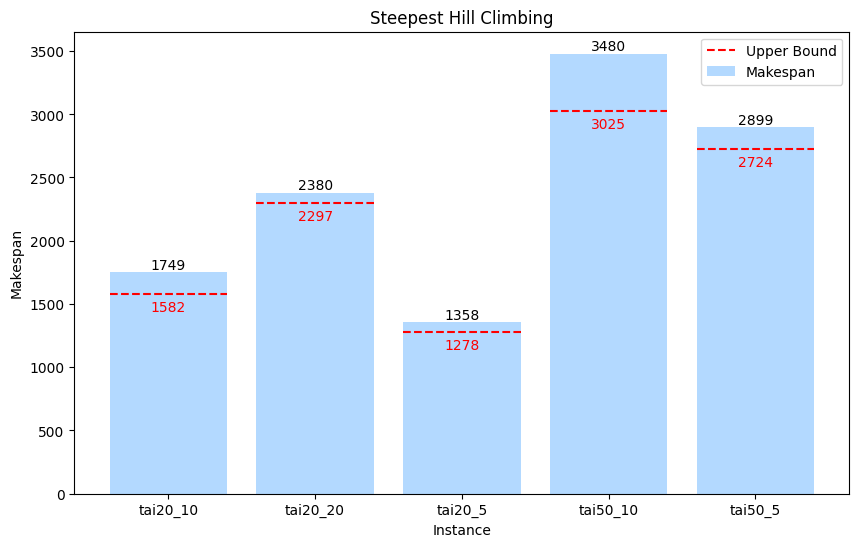

In [45]:
plot_test(results_df4,"Steepest Hill Climbing")

In [46]:
results_df5 = pd.DataFrame(columns=["File Name", "Instance", "Upper Bound", "Initial solution", "Makespan"])
for file_name in file_names:
    print(file_name)
    taillard = load_taillard(path="benchmarks/"+file_name)
    data = np.array(taillard[0]['jobs'])
    permutation = np.random.permutation(len(data)).tolist()
    permutation , initial_solution = neh_algorithm(data.T)
    neighbor, neighbor_cmax, _ = stochastic_hill_climbing(permutation, data.T , 10000)
    
    new_row = pd.DataFrame({"File Name": [file_name[:-4]],
                                    #"Generated Solution": neighbor,
                                    "Instance": [0],
                                    "Upper Bound": [taillard[0]['upper_bound']],
                                    "Initial solution": [int(initial_solution)],
                                    "Makespan": [int(neighbor_cmax)]})
    
    results_df5 = pd.concat([results_df5, new_row], ignore_index=True)
        
results_df5
# plot_gantt(np.array(data), neighbor)

tai20_10.txt
tai20_20.txt
tai20_5.txt
tai50_10.txt
tai50_5.txt


,File Name,Instance,Upper Bound,Initial solution,Makespan
0,tai20_10,0,1582,1769,1723
1,tai20_20,0,2297,2391,2357
2,tai20_5,0,1278,1358,1358
3,tai50_10,0,3025,3513,3480
4,tai50_5,0,2724,2899,2899


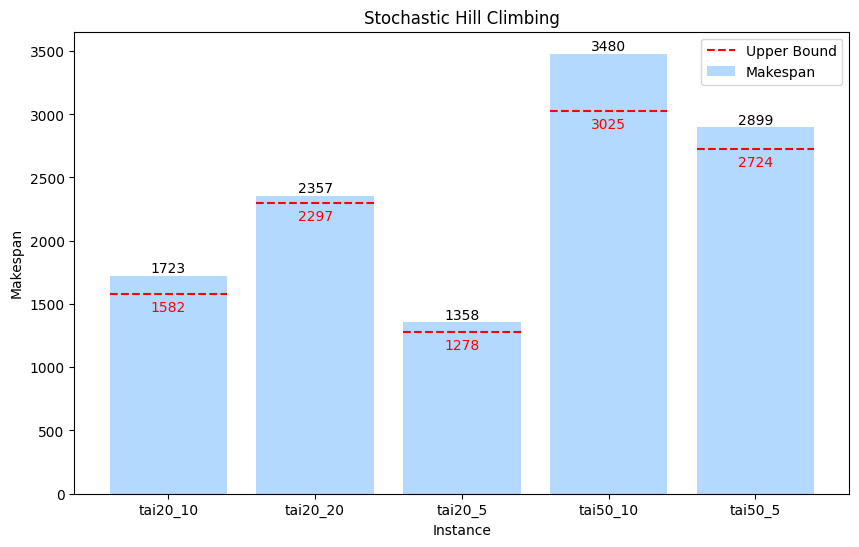

In [47]:
plot_test(results_df5,"Stochastic Hill Climbing")

In [48]:
results_df6 = pd.DataFrame(columns=["File Name", "Instance", "Upper Bound", "Initial solution", "Makespan"])

for file_name in file_names:
    print(file_name)
    taillard = load_taillard(path="benchmarks/"+file_name)
    data = np.array(taillard[0]['jobs'])
    permutation = np.random.permutation(len(data)).tolist()
    initial_solution = evaluate_sequence(permutation, data)
    fs = Flowshop(data=data, nb_machines=len(data), nb_jobs=len(data[0]))
    _,_,neighbor_cmax,_ = fs.simulated_annealing()
    new_row = pd.DataFrame({"File Name": [file_name[:-4]],
                                    #"Generated Solution": neighbor,
                                    "Instance": [0],
                                    "Upper Bound": [taillard[0]['upper_bound']],
                                    "Initial solution": [int(initial_solution)],
                                    "Makespan": [int(neighbor_cmax)]})
    
    results_df6 = pd.concat([results_df6, new_row], ignore_index=True)
    
results_df

tai20_10.txt
tai20_20.txt
tai20_5.txt
tai50_10.txt
tai50_5.txt


,File Name,Instance,Upper Bound,Initial solution,Makespan
0,tai20_10,0,1582,2140,2157
1,tai20_20,0,2297,2928,2679
2,tai20_5,0,1278,1543,1510
3,tai50_10,0,3025,3741,3931
4,tai50_5,0,2724,3141,3255


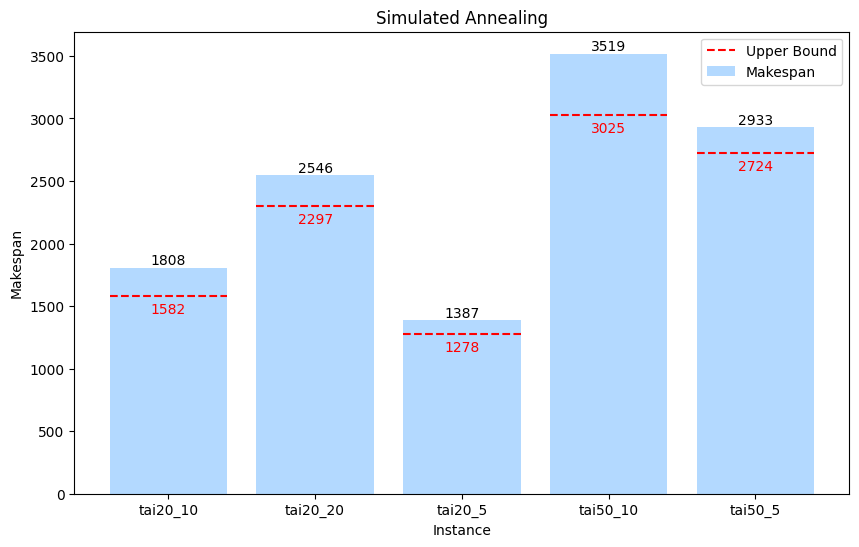

In [49]:
plot_test(results_df6,"Simulated Annealing")

### Compariason

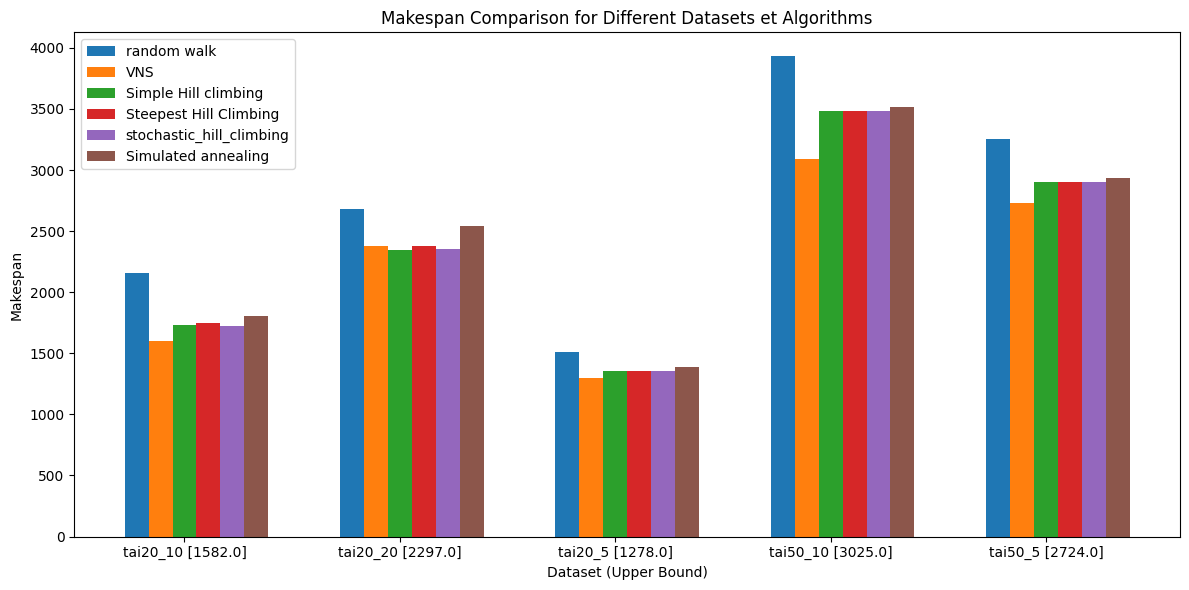

In [50]:
# Combine all dataframes into a single dataframe
result_dfs = [results_df, results_df2, results_df3, results_df4, results_df5, results_df6]
combined_df = pd.concat(result_dfs)

# Group the combined dataframe by 'File Name' and aggregate the makespan values for each algorithm
grouped_df = combined_df.groupby('File Name')['Makespan'].apply(list).reset_index()

# Define algorithm names
algorithm_names = ["random walk", "VNS", "Simple Hill climbing", "Steepest Hill Climbing", "stochastic_hill_climbing", "Simulated annealing"]

# Plotting
plt.figure(figsize=(12, 6))

# Loop through each algorithm
bar_width = 0.1  # Adjust bar width
dataset_space = 0.3  # Adjust space between datasets
num_datasets = len(grouped_df)
for i, algorithm in enumerate(algorithm_names):
    bar_positions = np.arange(num_datasets) * (len(algorithm_names) * bar_width + dataset_space) + i * bar_width
    plt.bar(bar_positions, grouped_df['Makespan'].apply(lambda x: x[i]), width=bar_width, label=algorithm)

plt.xlabel('Dataset (Upper Bound)')
plt.ylabel('Makespan')
plt.title('Makespan Comparison for Different Datasets et Algorithms')

# Modify x-axis labels to include upper bound
x_labels = [f"{file_name} [{upper_bound}]" for file_name, upper_bound in zip(grouped_df['File Name'], combined_df.groupby('File Name')['Upper Bound'].mean())]
plt.xticks(np.arange(num_datasets) * (len(algorithm_names) * bar_width + dataset_space) + ((num_datasets - 1) * bar_width) / 2, x_labels)

plt.legend()
plt.tight_layout()
plt.show()

# Tests pour toutes les instances de Taillard 20x5

In [51]:
taillard = load_taillard('benchmarks/tai20_5.txt')

In [52]:
results_df = pd.DataFrame(columns=["Instance", "Upper Bound", "Initial solution", "Makespan"])
for i in range(len(taillard)):
    data = np.array(taillard[i]['jobs'])
    permutation = np.random.permutation(len(data)).tolist()
    initial_solution = evaluate_sequence(permutation, data)
    neighbor, neighbor_cmax, iterations  = random_walk(permutation , data, threshold=None, max_iterations=1000)
    
    new_row = pd.DataFrame({"Instance": [i],
                            "Upper Bound": [taillard[i]['upper_bound']],
                            "Initial solution": [int(initial_solution)],
                            "Makespan": [int(neighbor_cmax)]})
    
    results_df = pd.concat([results_df, new_row], ignore_index=True)
    
results_df

,Instance,Upper Bound,Initial solution,Makespan
0,0,1278,1605,1584
1,1,1359,1496,1433
2,2,1081,1348,1635
3,3,1293,1554,1691
4,4,1236,1400,1487
5,5,1195,1588,1414
6,6,1239,1506,1533
7,7,1206,1465,1519
8,8,1230,1576,1545
9,9,1108,1370,1545


In [53]:
results_df2 = pd.DataFrame(columns=["Instance", "Upper Bound", "Initial solution", "Makespan"])
for i in range(len(taillard)):
    data = np.array(taillard[i]['jobs'])
    permutation = np.random.permutation(len(data)).tolist()
    initial_solution = evaluate_sequence(permutation, data)
    neighbor, neighbor_cmax = vns(permutation, data, max_iterations=5, k_max=3)
    
    new_row = pd.DataFrame({"Instance": [i],
                            "Upper Bound": [taillard[i]['upper_bound']],
                            "Initial solution": [int(initial_solution)],
                            "Makespan": [int(neighbor_cmax)]})
    
    results_df2 = pd.concat([results_df2, new_row], ignore_index=True)

In [54]:
results_df3 = pd.DataFrame(columns=["Instance", "Upper Bound", "Initial solution", "Makespan"])
for i in range(len(taillard)):
    data = np.array(taillard[i]['jobs'])
    permutation = np.random.permutation(len(data)).tolist()
    permutation , initial_solution = neh_algorithm(data.T)
    neighbor, neighbor_cmax, _ = simple_hill_climbing(permutation, data.T , 10000)
    
    new_row = pd.DataFrame({
                            "Instance": [i],
                            "Upper Bound": [taillard[i]['upper_bound']],
                            "Initial solution": [int(initial_solution)],
                            "Makespan": [int(neighbor_cmax)]})
    
    results_df3 = pd.concat([results_df3, new_row], ignore_index=True)

In [55]:
results_df4 = pd.DataFrame(columns=["Instance", "Upper Bound", "Initial solution", "Makespan"])
for i in range(len(taillard)):
    data = np.array(taillard[i]['jobs'])
    permutation = np.random.permutation(len(data)).tolist()
    permutation , initial_solution = neh_algorithm(data.T)
    neighbor, neighbor_cmax, _ = steepest_ascent_hill_climbing(permutation, data.T)
    
    new_row = pd.DataFrame({
                            "Instance": [i],
                            "Upper Bound": [taillard[i]['upper_bound']],
                            "Initial solution": [int(initial_solution)],
                            "Makespan": [int(neighbor_cmax)]})
    
    results_df4 = pd.concat([results_df4, new_row], ignore_index=True)

In [56]:
results_df5 = pd.DataFrame(columns=["Instance", "Upper Bound", "Initial solution", "Makespan"])
for i in range(len(taillard)):
    data = np.array(taillard[i]['jobs'])
    permutation = np.random.permutation(len(data)).tolist()
    permutation , initial_solution = neh_algorithm(data.T)
    neighbor, neighbor_cmax, _ = stochastic_hill_climbing(permutation, data.T , 10000)
    
    new_row = pd.DataFrame({
                            "Instance": [i],
                            "Upper Bound": [taillard[i]['upper_bound']],
                            "Initial solution": [int(initial_solution)],
                            "Makespan": [int(neighbor_cmax)]})
    
    results_df5 = pd.concat([results_df5, new_row], ignore_index=True)

In [57]:
results_df6 = pd.DataFrame(columns=["Instance", "Upper Bound", "Initial solution", "Makespan"])
for i in range(len(taillard)):
    data = np.array(taillard[i]['jobs'])
    permutation = np.random.permutation(len(data)).tolist()
    permutation , initial_solution = neh_algorithm(data.T)
    fs = Flowshop(data=data, nb_machines=len(data), nb_jobs=len(data[0]))
    _,_,neighbor_cmax,_ = fs.simulated_annealing()
    
    new_row = pd.DataFrame({
                            "Instance": [i],
                            "Upper Bound": [taillard[i]['upper_bound']],
                            "Initial solution": [int(initial_solution)],
                            "Makespan": [int(neighbor_cmax)]})
    
    results_df6 = pd.concat([results_df6, new_row], ignore_index=True)

In [58]:
cols = ["random walk", "VNS", "Simple Hill climbing", "Steepest Hill Climbing", "stochastic_hill_climbing", "Simulated annealing"]
df = pd.DataFrame(columns=cols)
for col, ds in zip(cols, [results_df, results_df2, results_df3, results_df4, results_df5, results_df6]):
    df[col] = ds['Makespan']
df['UB'] = results_df['Upper Bound']
df

,random walk,VNS,Simple Hill climbing,Steepest Hill Climbing,stochastic_hill_climbing,Simulated annealing,UB
0,1584,1339,1358,1358,1358,1390,1278
1,1433,1366,1426,1426,1426,1394,1359
2,1635,1098,1165,1165,1165,1280,1081
3,1691,1301,1505,1505,1505,1540,1293
4,1487,1250,1325,1325,1325,1360,1236
5,1414,1210,1377,1377,1377,1391,1195
6,1533,1259,1368,1368,1368,1310,1239
7,1519,1217,1380,1380,1380,1378,1206
8,1545,1261,1442,1442,1442,1420,1230
9,1545,1131,1278,1278,1278,1324,1108


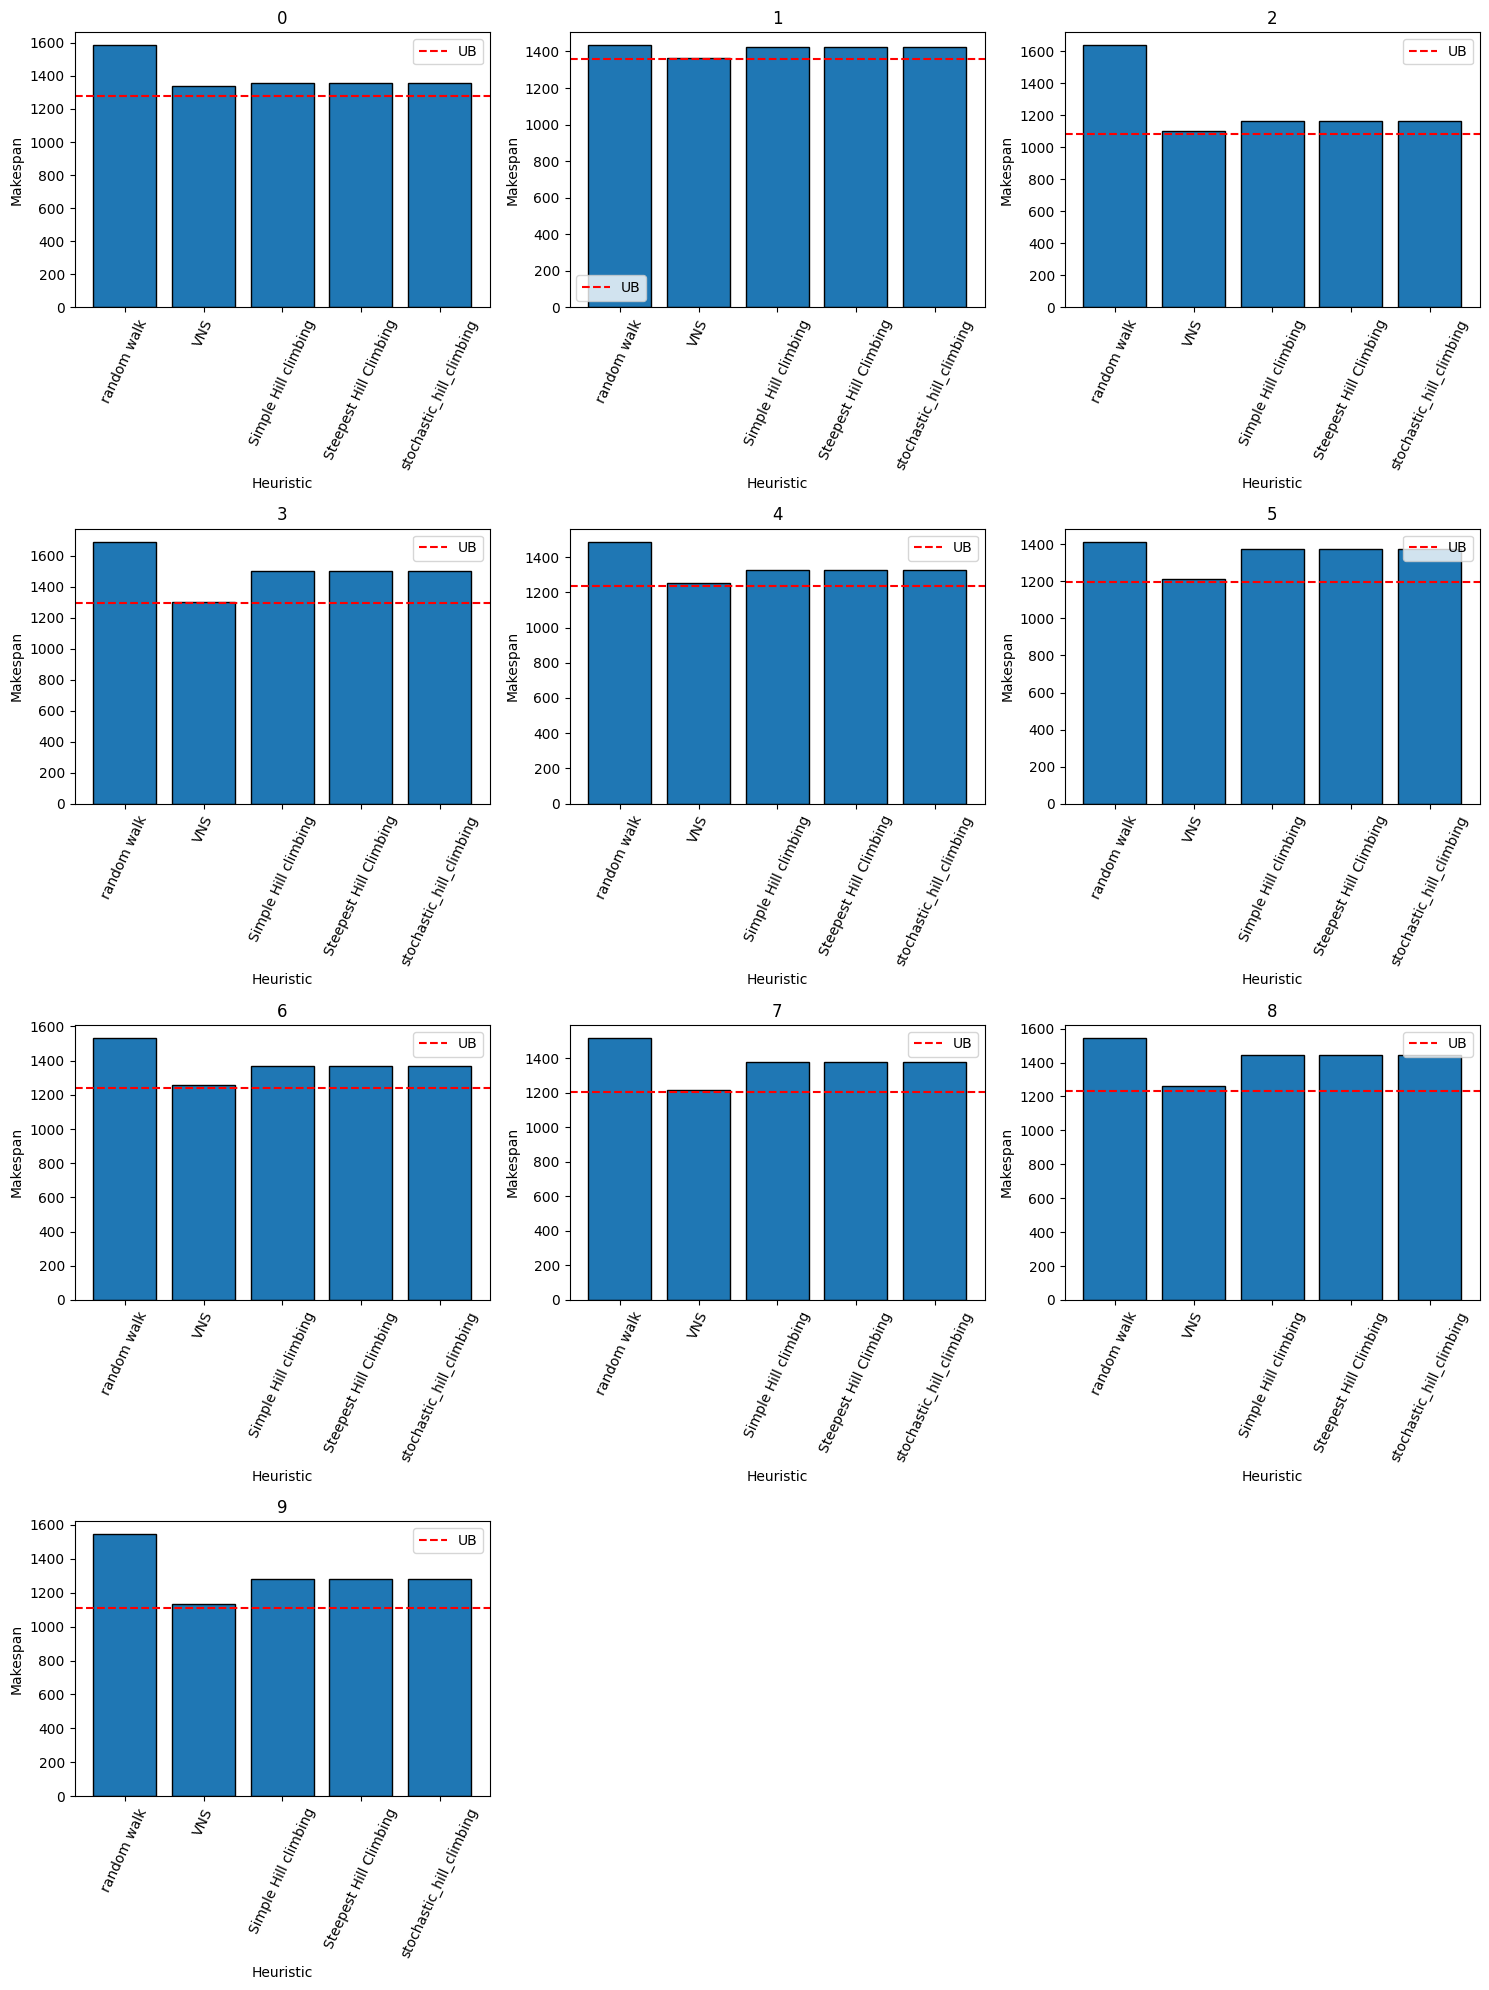

In [59]:
def plot_charts(df, rows, cols):
    num_plots = len(df.index)
    fig, axs = plt.subplots(rows, cols, figsize=(cols*5, rows*5))

    for i, (index, row) in enumerate(df.iterrows()):
        ax = axs[i//cols, i%cols]
        ax.bar(df.columns[:-2], row[:-2], edgecolor='black')
        ax.axhline(y=row['UB'], color='r', linestyle='--', label='UB')
        ax.set_title(index)
        ax.set_xlabel('Heuristic')
        ax.set_ylabel('Makespan')
        ax.set_xticks(range(len(df.columns[:-2])))
        ax.set_xticklabels(df.columns[:-2], rotation=65)
        ax.legend()
    
    # Hide any unused subplots
    for i in range(num_plots, rows*cols):
        axs[i//cols, i%cols].axis('off')

    plt.tight_layout()
    plt.show()
plot_charts(df, 4,3)